
Press (1) for Buying stock
Press (2) for Selling stock
Press (3) for Viewing portfolio
Press (4) for Visualization of risk metrics
Press (5) for Stock Analysis
Press (6) for Exit


Enter choice:  4



Press (1) for Beta Scatter plot
Press (2) for Sharpe Ratio Distribution Chart
Press (3) for Heatmap
Press (4) for Exit


Enter choice:  3


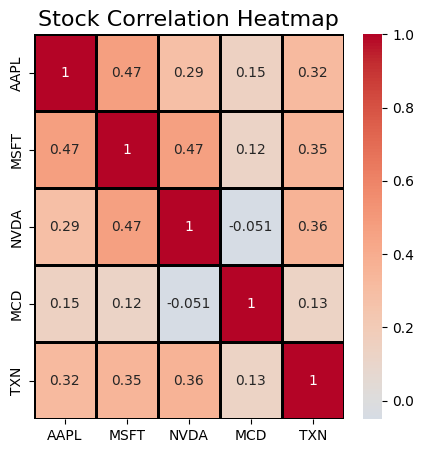


Press (1) for Beta Scatter plot
Press (2) for Sharpe Ratio Distribution Chart
Press (3) for Heatmap
Press (4) for Exit


In [ ]:
### importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from datetime import date,timedelta
# Function to load portfolio from CSV
def load_portfolio(csv_file):
    try:
        portfolio = pd.read_csv(csv_file)
        return portfolio
    except FileNotFoundError:
        return pd.DataFrame(columns=["Ticker", "Shares", "Value"])  

# Function to display portfolio data
def display_portfolio(portfolio):
    if portfolio is not None and not portfolio.empty:
        print("\nPortfolio Overview:")
        print(portfolio)
    else:
        print("No portfolio data to display.")

# Function to get the current stock price from Yahoo Finance
def get_stock_price(ticker):
    stock = yf.Ticker(ticker)
    todays_data = stock.history(period="1d")
    return todays_data['Close'].iloc[0]
# Function to get risk free rate
def get_risk_free_rate():
    treasury = yf.Ticker("^TNX")  
    data = treasury.history(period="1d")
    return data['Close'].iloc[-1] / 100 
#Function to get P/E Ratio
def calculate_pe_ratio(stock_symbol):
    stock = yf.Ticker(stock_symbol)
    stock_price = stock.history(period='1d')['Close'].iloc[0]
    eps = stock.info.get('trailingEps', None)
    growth_rate = stock.info.get('earningsGrowth', None)
    if eps and eps != 0:  # Make sure EPS is not None or zero
        pe_ratio = stock_price / eps
    else:
        pe_ratio = None
    return pe_ratio
#Function to get PEG Ratio
def calculate_peg_ratio(stock_symbol):
    stock = yf.Ticker(stock_symbol)
    stock_price = stock.history(period='1d')['Close'].iloc[0]
    eps = stock.info.get('trailingEps', None)
    growth_rate = stock.info.get('earningsGrowth', None)
    pe_ratio =calculate_pe_ratio(stock_symbol)
    if pe_ratio and growth_rate:
        peg_ratio = pe_ratio / (growth_rate * 100) 
    else:
        peg_ratio = None
    return peg_ratio
    

# Function to save portfolio to CSV
def save_portfolio(portfolio, csv_file):
    portfolio.to_csv(csv_file, index=False)

# Function to buy stocks
def buy_stock(ticker, quantity, portfolio):
    ticker = ticker.upper()  
    try:
        price = get_stock_price(ticker)
        print(f"Buying {quantity} shares of {ticker} at ${price:.2f} per share.")
    except Exception as e:
        print(f"Error fetching stock price for {ticker}: {e}")
        return portfolio  
    
    value = quantity * price  # Calculate total value of the purchase
    if ticker in portfolio['Ticker'].values:
        portfolio.loc[portfolio['Ticker'] == ticker, 'Shares'] += quantity
        portfolio.loc[portfolio['Ticker'] == ticker, 'Value'] += value
        print(f"Updated {ticker} with {quantity} additional shares.")
    else:
        new_entry = pd.DataFrame({
            "Ticker": [ticker],
            "Shares": [quantity],
            "Value": [value]
        })
        if not new_entry.empty:
            portfolio = pd.concat([portfolio, new_entry], ignore_index=True)
            print(f"Added {ticker} to portfolio with {quantity} shares.")
    
    return portfolio  

# Function to sell stocks
def sell_stock(ticker, quantity, portfolio):
    ticker = ticker.upper()  
    try:
        price = get_stock_price(ticker)
        print(f"Selling {quantity} shares of {ticker} at ${price:.2f} per share.")
    except Exception as e:
        print(f"Error fetching stock price for {ticker}: {e}")
        return portfolio  
    
    if ticker in portfolio['Ticker'].values:
        current_shares = portfolio.loc[portfolio['Ticker'] == ticker, 'Shares'].iloc[0]
        if current_shares < quantity:
            print("Not enough shares available.")
        else:
            portfolio.loc[portfolio['Ticker'] == ticker, 'Shares'] -= quantity
            portfolio.loc[portfolio['Ticker'] == ticker, 'Value'] -= quantity * price
            
            # Ensure Value doesn't go below zero
            if portfolio.loc[portfolio['Ticker'] == ticker, 'Value'].iloc[0] < 0:
                portfolio.loc[portfolio['Ticker'] == ticker, 'Value'] = 0
            
            print(f"Sold {quantity} shares of {ticker}.")
    else:
        print(f"{ticker} does not exist in portfolio")   
        
    return portfolio

# Function to update portfolio values with real-time prices
def update_portfolio_with_real_time_prices(portfolio):
    for i, row in portfolio.iterrows():
        ticker = row['Ticker']
        try:
            current_price = get_stock_price(ticker)
            portfolio.at[i, 'Value'] = row['Shares'] * current_price
        except Exception as e:
            print(f"Error updating {ticker}: {e}")
    return portfolio

# Function to get historical data for a given stock
def get_historical_data(ticker, period="1y"):
    stock = yf.Ticker(ticker)
    hist_data = stock.history(period=period)
    return hist_data['Close']

# Function to calculate returns from price data
def calculate_returns(price_series):
    returns = price_series.pct_change().dropna()
    return returns

# Function to calculate market returns
def calculate_market_returns(market_ticker="^GSPC", period="1y"):
    market_prices = get_historical_data(market_ticker, period)
    market_returns = calculate_returns(market_prices)
    return market_returns

# Function to calculate portfolio returns
def calculate_portfolio_returns(portfolio, period="1y"):
    portfolio_returns = None
    total_value = portfolio['Value'].sum()
    for _, row in portfolio.iterrows():
        ticker = row['Ticker']
        stock_value = row['Value']
        stock_weight = stock_value / total_value

        stock_prices = get_historical_data(ticker, period)
        stock_returns = calculate_returns(stock_prices)

        if portfolio_returns is None:
            portfolio_returns = stock_weight * stock_returns
        else:
            portfolio_returns += stock_weight * stock_returns

    return portfolio_returns
def calculate_beta(stock_symbol, market_symbol="^GSPC", start_date=None, end_date=date.today()):
    if start_date is None:
        start_date = end_date - timedelta(days=365)
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date) 
    market_data = yf.download(market_symbol, start=start_date, end=end_date)
    stock_data['Return'] = stock_data['Adj Close'].pct_change()
    market_data['Return'] = market_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()
    market_data = market_data.dropna()
    covariance = np.cov(stock_data['Return'], market_data['Return'])[0, 1]
    variance = market_data['Return'].var()
    beta = covariance / variance
    return beta

# Function to visualize the portfolio beta
def visualize_portfolio_beta(portfolio, market_ticker="^GSPC", period="1y"):
    portfolio_returns = calculate_portfolio_returns(portfolio, period)
    market_returns = calculate_market_returns(market_ticker, period)
    aligned_returns = pd.DataFrame({
        'Portfolio': portfolio_returns,
        'Market': market_returns
    }).dropna()
    plt.figure(figsize=(5, 5))
    plt.scatter(aligned_returns['Market'], aligned_returns['Portfolio'], alpha=0.5)
    plt.title('Portfolio Returns vs Market Returns')
    plt.xlabel(f'{market_ticker} Market Returns')
    plt.ylabel('Portfolio Returns')
    m, b = np.polyfit(aligned_returns['Market'], aligned_returns['Portfolio'], 1)
    plt.plot(aligned_returns['Market'], m * aligned_returns['Market'] + b, color='red', label=f'Beta = {m:.2f}')
    plt.legend()
    plt.show()
    return m

# Function to create a heatmap of portfolio stock correlations
def Heatmap_of_portfolio(portfolio, period="1y"):
    stock_returns = {}
    for _, row in portfolio.iterrows():
        ticker = row['Ticker']
        stock_returns[ticker] = calculate_returns(get_historical_data(ticker, period))
    returns_df = pd.DataFrame(stock_returns)
    corr_matrix = returns_df.corr()
    plt.figure(figsize=(5, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black')
    plt.title('Stock Correlation Heatmap', fontsize=16)
    plt.show()
def visualize_sharpe_ratio_distribution(portfolio, risk_free_rate, period="1y"):
    sharpe_ratios = []
    for _, row in portfolio.iterrows():
        ticker = row['Ticker']
        stock_prices = get_historical_data(ticker, period)
        stock_returns = calculate_returns(stock_prices)
        avg_return = stock_returns.mean()
        std_dev = stock_returns.std()
        sharpe_ratio = (avg_return - risk_free_rate) / std_dev
        sharpe_ratios.append(sharpe_ratio)
    plt.figure(figsize=(5, 5))
    sns.histplot(sharpe_ratios, bins=10, kde=True)
    plt.title('Sharpe Ratio Distribution', fontsize=16)
    plt.xlabel('Sharpe Ratio', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid()
    plt.show()

# Main Program Loop
portfolio = load_portfolio("portfolio.csv")  
update_portfolio_with_real_time_prices(portfolio)

while True:
    print("\nPress (1) for Buying stock")
    print("Press (2) for Selling stock")
    print("Press (3) for Viewing portfolio")
    print("Press (4) for Visualization of risk metrics")
    print("Press (5) for Stock Analysis")
    print("Press (6) for Exit")
    choice = input("Enter choice: ")
    
    if choice == '1':
        ticker = input("Enter ticker according to Yahoo Finance: ")
        qty = int(input("Enter number of shares: "))
        portfolio = buy_stock(ticker, qty, portfolio)  
        save_portfolio(portfolio, "portfolio.csv")  
    elif choice == '2':
        ticker = input("Enter ticker according to Yahoo Finance: ")
        qty = int(input("Enter number of shares: "))
        portfolio = sell_stock(ticker, qty, portfolio)  
        save_portfolio(portfolio, "portfolio.csv")   
    elif choice == '3':
        display_portfolio(portfolio)
    elif choice == '4':
        while True:
            print("\nPress (1) for Beta Scatter plot")
            print("Press (2) for Sharpe Ratio Distribution Chart")
            print("Press (3) for Heatmap")
            print("Press (4) for Exit")
            ch = input("Enter choice: ")
            if ch == '1':
                print(f"beta is {visualize_portfolio_beta(portfolio):.2f}")
            elif ch == '2':
                risk_free_rate = get_risk_free_rate()
                visualize_sharpe_ratio_distribution(portfolio, risk_free_rate)
            elif ch == '3':
                Heatmap_of_portfolio(portfolio)
            elif ch == '4':
                print("Exited Visualization Menu")
                break
            else:
                print("Invalid choice")
    elif choice=='5':
        ticker=input("Enter ticker according to Yahoo Finance: ")
        print(f"The Beta of the Stock is {calculate_beta(ticker.upper()):.2f}")
        print(f"The P/E Ratio of the Stock is {calculate_pe_ratio(ticker.upper()):.2f}")
        print(f"The PEG Ratio of the Stock is {calculate_peg_ratio(ticker.upper()):.2f}")
    elif choice == '6':
        print("Thank you for using the Portfolio Visualizer!")
        break
    else:
        print("Invalid input, please choose again.")
